In [2]:
import duckdb
import pandas as pd
import numpy as np
import pseudopeople as psp
import os
import shutil
import pathlib

In [3]:
# --- Configuration ---
full_data_path = (
    '/mnt/team/simulation_science/pub/models/vivarium_census_prl_synth_pop/results/release_02_yellow/'
    'full_data/united_states_of_america/2023_08_21_16_35_27/final_results/2023_08_31_15_58_01/'
    'pseudopeople_simulated_population_usa_2_0_0/'
)

# Target Sizes
n1a_target = 500_000
n1b_target = 100_000
n2_target  = 5_000_000
overlap_a_target = 100_000 
overlap_b_target = 20_000

# Oversample factor: increased to 1.5x to ensure we have enough overlap after non-response dropouts
OVERSAMPLE = 1.5 

# Adjusted Sampling Targets for DuckDB
n2_sample = int(n2_target * OVERSAMPLE)
n1a_sample = int(n1a_target * OVERSAMPLE)
n1b_sample = int(n1b_target * OVERSAMPLE)
overlap_a_sample = int(overlap_a_target * OVERSAMPLE)
overlap_b_sample = int(overlap_b_target * OVERSAMPLE)

# Temp directory
temp_dir = "temp_psp_processing_v4"
if os.path.exists(temp_dir):
    shutil.rmtree(temp_dir)
os.makedirs(temp_dir, exist_ok=True)

In [4]:
# --- 1. DuckDB Setup & Deduplication ---
con = duckdb.connect()
root_path = pathlib.Path(full_data_path)

def find_parquet_source(root, possible_names):
    if root.is_file(): return str(root)
    for name in possible_names:
        candidate = root / name
        if candidate.exists():
            return str(candidate / "*.parquet")
    raise FileNotFoundError(f"Could not find any of {possible_names} in {root}")

census_glob = find_parquet_source(root_path, ["decennial_census", "decennial_census_observer"])
ssn_glob = find_parquet_source(root_path, ["social_security", "social_security_observer"])

print("Creating deduplicated view of Florida 2020 population...")

# CENSUS VIEW: Deduplicated and Filtered
con.execute(f"""
    CREATE OR REPLACE VIEW raw_census AS 
    SELECT * FROM read_parquet('{census_glob}') 
    WHERE state = 'FL' AND year = 2020
    QUALIFY row_number() OVER (PARTITION BY simulant_id ORDER BY year DESC) = 1
""")

# SSN VIEW: Raw (No deduplication yet - deferred to avoid OOM)
con.execute(f"CREATE OR REPLACE VIEW raw_ssn AS SELECT simulant_id, ssn FROM read_parquet('{ssn_glob}')")

Creating deduplicated view of Florida 2020 population...


In [5]:
# --- Safety Check: Ensure we actually found Florida records ---
fl_count = con.execute("SELECT count(*) FROM raw_census").fetchone()[0]
if fl_count == 0:
    raise ValueError("CRITICAL: No records found for state='FL'. Check your path and state filter.")
print(f"Found {fl_count:,} Florida records. Proceeding...")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Found 21,123,234 Florida records. Proceeding...


In [6]:
# --- 2. Rates Setup ---
wide = pd.DataFrame([
    { "age_start": 0  , "age_end": 1  , "male_pct": 0.592505, "female_pct": 0.620853 },
    { "age_start": 1  , "age_end": 2  , "male_pct": 0.901531, "female_pct": 1.198858 },
    { "age_start": 2  , "age_end": 5  , "male_pct": 1.095433, "female_pct": 1.388232 },
    { "age_start": 5  , "age_end": 10 , "male_pct": 0.781292, "female_pct": 0.984379 },
    { "age_start": 10 , "age_end": 15 , "male_pct": 0.646349, "female_pct": 0.868245 },
    { "age_start": 15 , "age_end": 20 , "male_pct": 0.749407, "female_pct": 1.238615 },
    { "age_start": 20 , "age_end": 25 , "male_pct": 0.972845, "female_pct": 1.887296 },
    { "age_start": 25 , "age_end": 30 , "male_pct": 1.326132, "female_pct": 2.976430 },
    { "age_start": 30 , "age_end": 35 , "male_pct": 1.697664, "female_pct": 4.290650 },
    { "age_start": 35 , "age_end": 40 , "male_pct": 2.194696, "female_pct": 5.922532 },
    { "age_start": 40 , "age_end": 45 , "male_pct": 2.943806, "female_pct": 7.699050 },
    { "age_start": 45 , "age_end": 50 , "male_pct": 4.121518, "female_pct": 9.565526 },
    { "age_start": 50 , "age_end": 55 , "male_pct": 6.482578, "female_pct": 11.593801 },
    { "age_start": 55 , "age_end": 60 , "male_pct": 10.266023, "female_pct": 13.965508 },
    { "age_start": 60 , "age_end": 65 , "male_pct": 15.563234, "female_pct": 16.202010 },
    { "age_start": 65 , "age_end": 70 , "male_pct": 20.944225, "female_pct": 18.197830 },
    { "age_start": 70 , "age_end": 75 , "male_pct": 25.022162, "female_pct": 19.724099 },
    { "age_start": 75 , "age_end": 80 , "male_pct": 27.368397, "female_pct": 20.487546 },
    { "age_start": 80 , "age_end": 85 , "male_pct": 29.293099, "female_pct": 20.532737 },
    { "age_start": 85 , "age_end": 90 , "male_pct": 31.142438, "female_pct": 21.836378 },
    { "age_start": 90 , "age_end": 95 , "male_pct": 31.174155, "female_pct": 20.399291 },
    { "age_start": 95 , "age_end": 125, "male_pct": 32.361739, "female_pct": 21.514415 },
])

# --- 2. Reshape for SQL (No parsing needed!) ---
long_rates = pd.concat([
    wide[["age_start", "age_end"]].assign(sex="Male", prevalence_pct=wide["male_pct"]),
    wide[["age_start", "age_end"]].assign(sex="Female", prevalence_pct=wide["female_pct"]),
], ignore_index=True)

con.execute("CREATE OR REPLACE TABLE rates AS SELECT * FROM long_rates")

In [7]:
# --- 3. Weighted Sampling Logic ---
print(f"Sampling oversize cohorts ({OVERSAMPLE}x)...")

# DF_2 (Cancer Cohort)
# Uses prevalence_pct / 100 to get probability
con.execute(f"""
    CREATE OR REPLACE TABLE df_2_ids AS
    WITH weighted_pop AS (
        SELECT 
            c.simulant_id,
            r.prevalence_pct,
            -- Convert Percentage (0-100) to Probability (0-1)
            (r.prevalence_pct / 100.0) as prob_weight
        FROM raw_census c
        JOIN rates r 
          ON c.sex = r.sex 
          AND c.age >= r.age_start 
          AND c.age < r.age_end
    )
    SELECT simulant_id FROM weighted_pop
    ORDER BY -ln(random()) / prob_weight
    LIMIT {n2_sample}
""")

# DF_1A (Overlap + Rest)
con.execute(f"""
    CREATE OR REPLACE TABLE df_1a_ids AS
    SELECT * FROM (SELECT simulant_id FROM df_2_ids ORDER BY random() LIMIT {overlap_a_sample})
    UNION ALL
    SELECT * FROM (
        SELECT c.simulant_id 
        FROM raw_census c
        WHERE c.simulant_id NOT IN (SELECT simulant_id FROM df_2_ids)
        ORDER BY random() 
        LIMIT {n1a_sample - overlap_a_sample}
    )
""")

# DF_1B (Overlap + Rest)
con.execute(f"""
    CREATE OR REPLACE TABLE df_1b_ids AS
    SELECT * FROM (SELECT simulant_id FROM df_2_ids ORDER BY random() LIMIT {overlap_b_sample})
    UNION ALL
    SELECT * FROM (
        SELECT c.simulant_id 
        FROM raw_census c
        WHERE c.simulant_id NOT IN (SELECT simulant_id FROM df_2_ids)
        ORDER BY random() 
        LIMIT {n1b_sample - overlap_b_sample}
    )
""")

Sampling oversize cohorts (1.5x)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [8]:
# --- 4. Stage Data & Copy Changelog ---
changelog_src = root_path / "CHANGELOG.rst"
if not changelog_src.exists():
    if root_path.parent.joinpath("CHANGELOG.rst").exists():
        changelog_src = root_path.parent / "CHANGELOG.rst"

def save_subset_for_psp(table_name, dataset_name):
    root_out = os.path.join(temp_dir, dataset_name)
    target_dir = os.path.join(root_out, "decennial_census")
    os.makedirs(target_dir, exist_ok=True)
    if changelog_src.exists():
        shutil.copy(changelog_src, os.path.join(root_out, "CHANGELOG.rst"))

    print(f"Staging {dataset_name} to {target_dir}...")
    con.execute(f"""
        COPY (
            SELECT c.* FROM raw_census c 
            JOIN {table_name} t ON c.simulant_id = t.simulant_id
        ) TO '{target_dir}/decennial_census_observer.parquet' (FORMAT PARQUET)
    """)
    return root_out

path_2 = save_subset_for_psp("df_2_ids", "df_2")
path_1a = save_subset_for_psp("df_1a_ids", "df_1a")
path_1b = save_subset_for_psp("df_1b_ids", "df_1b")

Staging df_2 to temp_psp_processing_v4/df_2/decennial_census...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Staging df_1a to temp_psp_processing_v4/df_1a/decennial_census...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Staging df_1b to temp_psp_processing_v4/df_1b/decennial_census...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [9]:
# --- 5. Generate Noised Census ---
def get_config(addr_missing):
    return {
        "decennial_census": {
            "column_noise": {
                "street_number": {"leave_blank": {"cell_probability": addr_missing}},
                "street_name":   {"leave_blank": {"cell_probability": addr_missing}},
                "unit_number":   {"leave_blank": {"cell_probability": addr_missing}},
                "city":          {"leave_blank": {"cell_probability": addr_missing}},
                "state":         {"leave_blank": {"cell_probability": addr_missing}},
                "zipcode":       {"leave_blank": {"cell_probability": addr_missing}},
            }
        }
    }

print("Running pseudopeople generation...")
# df_2: 1% missing addr
df_2_oversampled = psp.generate_decennial_census(source=path_2, seed=42, config=get_config(0.01))
# df_1a: 5% missing addr
df_1a_oversampled = psp.generate_decennial_census(source=path_1a, seed=1, config=get_config(0.05))
# df_1b: 5% missing addr (CHANGED from 0.01 to 0.05)
df_1b_oversampled = psp.generate_decennial_census(source=path_1b, seed=1, config=get_config(0.05))

Running pseudopeople generation...


Applying noise:   0%|          | 0/15 [00:00<?, ?type/s]

Applying noise:   0%|          | 0/15 [00:00<?, ?type/s]

Applying noise:   0%|          | 0/15 [00:00<?, ?type/s]

In [10]:
# --- 6. Post-Process Downsampling (Enforce Exact Overlaps) ---
print("Downsampling to exact targets...")

rng_final = np.random.default_rng(999)

# 1. Identify Survivor Sets (who is actually in the data after psp processing?)
ids_2 = set(df_2_oversampled.simulant_id)
ids_1a = set(df_1a_oversampled.simulant_id)
ids_1b = set(df_1b_oversampled.simulant_id)

# 2. Find Potential Overlaps
pool_overlap_a = list(ids_2.intersection(ids_1a))
pool_overlap_b = list(ids_2.intersection(ids_1b))

# 3. Select Target Overlaps (Force these IDs to stay)
final_count_overlap_a = min(len(pool_overlap_a), overlap_a_target)
final_count_overlap_b = min(len(pool_overlap_b), overlap_b_target)

final_overlap_ids_a = set(rng_final.choice(pool_overlap_a, size=final_count_overlap_a, replace=False))
final_overlap_ids_b = set(rng_final.choice(pool_overlap_b, size=final_count_overlap_b, replace=False))

# 4. Construct Final ID Lists
# DF_2: Contains ALL Overlap A + ALL Overlap B + Remainder from (DF_2 - Overlaps)
all_overlaps_for_2 = final_overlap_ids_a.union(final_overlap_ids_b)
remainder_candidates_2 = list(ids_2 - all_overlaps_for_2)
remainder_count_2 = n2_target - len(all_overlaps_for_2)
final_remainder_2 = set(rng_final.choice(remainder_candidates_2, size=remainder_count_2, replace=False))
final_ids_2 = all_overlaps_for_2.union(final_remainder_2)

# DF_1A: Contains ALL Overlap A + Remainder from (DF_1A - Overlap A)
remainder_candidates_1a = list(ids_1a - final_overlap_ids_a)
remainder_count_1a = n1a_target - len(final_overlap_ids_a)
final_remainder_1a = set(rng_final.choice(remainder_candidates_1a, size=remainder_count_1a, replace=False))
final_ids_1a = final_overlap_ids_a.union(final_remainder_1a)

# DF_1B: Contains ALL Overlap B + Remainder from (DF_1B - Overlap B)
remainder_candidates_1b = list(ids_1b - final_overlap_ids_b)
remainder_count_1b = n1b_target - len(final_overlap_ids_b)
final_remainder_1b = set(rng_final.choice(remainder_candidates_1b, size=remainder_count_1b, replace=False))
final_ids_1b = final_overlap_ids_b.union(final_remainder_1b)

# 5. Filter Dataframes
df_2_final = df_2_oversampled[df_2_oversampled.simulant_id.isin(final_ids_2)].copy()
df_1a_final = df_1a_oversampled[df_1a_oversampled.simulant_id.isin(final_ids_1a)].copy()
df_1b_final = df_1b_oversampled[df_1b_oversampled.simulant_id.isin(final_ids_1b)].copy()


Downsampling to exact targets...


In [11]:
len(df_1a_oversampled), len(set(df_1a_oversampled.simulant_id))#, len(common_1a), overlap_a_target

(733903, 733902)

In [12]:
# --- 7. SSN Noise (Corrected for Targeted Missingness) ---
def swap_two_ssn(x, rng):
    if pd.isna(x): return x
    s = str(x)
    digits = [ch for ch in s if ch.isdigit()]
    if len(digits) < 2: return s
    i = int(rng.integers(0, len(digits) - 1))
    digits[i], digits[i+1] = digits[i+1], digits[i]
    it = iter(digits)
    return "".join([next(it) if ch.isdigit() else ch for ch in s])

def attach_noised_ssn(df_census, ssn_missing_target_rate, ssn_transposed, seed):
    # Fetch SSNs (Deduplicated)
    ids_to_fetch = pd.DataFrame({'simulant_id': df_census.simulant_id.unique()})
    con.register('request_ids', ids_to_fetch)
    
    ssn_df = con.execute("""
        SELECT t.simulant_id, s.ssn
        FROM request_ids t
        LEFT JOIN raw_ssn s ON t.simulant_id = s.simulant_id
        QUALIFY row_number() OVER (PARTITION BY t.simulant_id ORDER BY s.ssn) = 1
    """).df()
    
    rng = np.random.default_rng(seed)
    
    # --- Corrected Missingness Logic: Target-Based ---
    # 1. Check current missingness (inherent in simulation)
    current_missing_mask = ssn_df['ssn'].isna()
    current_count = current_missing_mask.sum()
    total_count = len(ssn_df)
    target_count = int(total_count * ssn_missing_target_rate)
    
    # 2. Calculate how many MORE we need to remove to hit target
    to_remove = target_count - current_count
    
    if to_remove > 0:
        # Select 'to_remove' indices from the PRESENT SSNs only
        present_indices = ssn_df.index[~current_missing_mask].to_numpy()
        remove_indices = rng.choice(present_indices, size=to_remove, replace=False)
        ssn_df.loc[remove_indices, 'ssn'] = pd.NA
    elif to_remove < 0:
        # If simulation already has more missingness than requested, we can't "fix" it, just warn.
        print(f"WARNING: Dataset already has {current_count/total_count:.2%} missing SSNs, which is higher than target {ssn_missing_target_rate:.2%}. No additional missingness applied.")

    # --- Transposition Logic (Applied to remaining valid SSNs) ---
    # TODO: include orig_ssn column to make it easier to confirm that transpositions happen as planned
    if ssn_transposed > 0:
        valid_mask = ssn_df['ssn'].notna()
        n_valid = valid_mask.sum()
        if n_valid > 0:
            transpose_mask = (rng.random(n_valid) < ssn_transposed)
            subset_idx = ssn_df.index[valid_mask]
            target_idx = subset_idx[transpose_mask]
            ssn_df.loc[target_idx, 'ssn'] = ssn_df.loc[target_idx, 'ssn'].apply(lambda x: swap_two_ssn(x, rng))
    
    if 'ssn' in df_census.columns:
        df_census = df_census.drop(columns=['ssn'])
        
    return df_census.merge(ssn_df, on='simulant_id', how='left')

print("Attaching SSNs with corrected noise targets...")
# df_2: 5% SSN missing
df_2_final = attach_noised_ssn(df_2_final, ssn_missing_target_rate=0.05, ssn_transposed=0.0, seed=42)
# df_1a: 20% SSN missing
df_1a_final = attach_noised_ssn(df_1a_final, ssn_missing_target_rate=0.20, ssn_transposed=0.01, seed=1)
# df_1b: 20% SSN missing
df_1b_final = attach_noised_ssn(df_1b_final, ssn_missing_target_rate=0.20, ssn_transposed=0.01, seed=1)

Attaching SSNs with corrected noise targets...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [13]:
print("\nFinal Verification:")
print(f"df_2  Size: {len(df_2_final)} (Target: {n2_target})")
print(f"df_1a Size: {len(df_1a_final)} (Target: {n1a_target})")
print(f"df_1b Size: {len(df_1b_final)} (Target: {n1b_target})")
print(f"df_1a Overlap: {df_1a_final.simulant_id.isin(df_2_final.simulant_id).sum()} (Target: {overlap_a_target})")
print(f"df_1b Overlap: {df_1b_final.simulant_id.isin(df_2_final.simulant_id).sum()} (Target: {overlap_b_target})")


Final Verification:
df_2  Size: 5000012 (Target: 5000000)
df_1a Size: 500001 (Target: 500000)
df_1b Size: 100000 (Target: 100000)
df_1a Overlap: 119731 (Target: 100000)
df_1b Overlap: 23958 (Target: 20000)


In [14]:
# Cleanup
try:
    shutil.rmtree(temp_dir)
except:
    pass

In [15]:
df_2_final.simulant_id.value_counts().value_counts()

count
1    4999988
2         12
Name: count, dtype: int64

In [16]:
df_1a_final.simulant_id.value_counts().value_counts()

count
1    499999
2         1
Name: count, dtype: int64

In [17]:
df_1b_final.simulant_id.value_counts().value_counts()

count
1    100000
Name: count, dtype: int64

In [18]:
df_2_final.simulant_id.isin(df_1b_final.simulant_id).sum(), overlap_b_target

(23958, 20000)

In [19]:
df_2_final.simulant_id.isin(df_1a_final.simulant_id).sum(), overlap_a_target

(119731, 100000)

In [20]:
df_2_final

,simulant_id,household_id,first_name,middle_initial,last_name,age,date_of_birth,street_number,street_name,unit_number,city,state,zipcode,housing_type,relationship_to_reference_person,sex,race_ethnicity,year,ssn
0,4369_263663,4369_105870,Jeannie,C,Myers,74,03/26/1945,250,brookwood place,NaN,jacksonville,FL,34243,Household,Reference person,Female,White,2020,523-71-6000
1,4369_40488,4369_16262,Gary,R,Tidwell,71,04/13/1948,NaN,county road 447,NaN,venice,FL,34228,Household,Reference person,NaN,White,2020,095-35-2701
2,4369_470922,4369_189591,James,F,Rooks,64,02/22/1956,706,red barn lane,NaN,fort myers,FL,32210,Household,Reference person,Male,Black,2020,716-98-3434
3,4369_75674,4369_30308,Abigail,K,Traicoff,30,07/22/1989,393,10th avenue south,NaN,sanford,FL,33430,Household,Biological child,Female,White,2020,896-68-5222
4,4369_902746,4369_362994,Richard,R,Hecox,72,12/03/1947,1645,nrth california street,NaN,rockledge,FL,32250,Household,Reference person,Male,White,2020,293-87-9161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000007,7292_971865,7292_91485,Leslie,T,White Mccaskill,20,10/03/1999,11,26th av sth,NaN,boca raton,FL,32216,Household,Other relative,Female,Black,2020,307-06-2404
5000008,9024_983367,9024_191286,David,B,Ross,22,01/06/1998,8415,saddleback road,NaN,clearwater,FL,33614,Household,Other relative,Male,Black,2020,684-15-1255
5000009,771_981967,771_356717,Christina,J,Royalty,18,04/11/2001,23016,southern gln dr,NaN,lakeland,FL,33626,Household,Other relative,Female,White,2020,213-62-3365
5000010,131_974487,131_254389,Simone,J,Feller,19,08/06/2000,5271,s wayne ave,NaN,kissimmee,FL,32708,Household,Other relative,Female,White,2020,323-94-3479


In [21]:

df_1a_final

,simulant_id,household_id,first_name,middle_initial,last_name,age,date_of_birth,street_number,street_name,unit_number,city,state,zipcode,housing_type,relationship_to_reference_person,sex,race_ethnicity,year,ssn
0,4621_252051,4621_101408,Helen,L,Frazier,77,02/21/1943,2411,south basin creek avenue,NaN,st. petersburg,FL,33612,Household,Reference person,Female,White,2020,471-65-7390
1,4621_561506,4621_225911,Carole,M,Orton,56,02/29/1964,22003,NaN,NaN,saint augustine,NaN,NaN,Household,Reference person,Female,White,2020,162-18-9229
2,4621_898740,4621_361475,Damien,D,Wrigley,13,05/27/2006,140123,e webster pl,apt 200,melbourne,FL,32935,Household,Adopted child,Male,White,2020,555-06-0384
3,4622_65405,4622_26361,Giavanna,B,Franklin,13,05/22/2006,19427,seminole tr,NaN,melbourne,FL,34683,Household,Biological child,Female,White,2020,096-70-7474
4,4637_395750,4637_158950,Samuel,B,Clay,15,08/27/2004,5171,mary avenue,NaN,jacksonville,FL,32218,Household,Biological child,Male,Black,2020,765-22-9334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499996,7264_1017477,7264_410437,Kimberly,M,Lim,33,02/24/1987,54,wind watch drive,NaN,surfside,FL,33196,Other noninstitutional,Opposite-sex spouse,Female,Asian,2020,856-26-9913
499997,8221_747479,8221_300420,Kathryn,K,Simpson,37,04/20/1982,4532,forest avenue,NaN,pittman,FL,34221,Household,Reference person,Female,White,2020,<NA>
499998,6144_830177,6144_333474,Anthony,G,Clarkson,33,04/22/1986,1621,3 avenu,NaN,jacksonville,FL,32940,Household,Biological child,Male,White,2020,<NA>
499999,6191_120356,6191_48319,Devon,D,Garcia,19,02/26/2001,3209,beard st,NaN,north lauderdale,FL,33157,Household,Grandchild,Male,Latino,2020,040-60-2856


In [22]:

df_1b_final

,simulant_id,household_id,first_name,middle_initial,last_name,age,date_of_birth,street_number,street_name,unit_number,city,state,zipcode,housing_type,relationship_to_reference_person,sex,race_ethnicity,year,ssn
0,1069_670733,1069_269806,Margarita,M,Fortner,46,09/19/1973,4841,madison st,NaN,poinciana,FL,34135,Household,Reference person,Female,White,2020,522-32-9238
1,1074_773071,1074_310447,Ann,T,House,50,05/03/1969,NaN,n l st,NaN,hawthorne,FL,32561,Household,Other relative,Female,White,2020,586-55-6736
2,1091_844978,1091_339533,Lauren,S,Ebert,30,10/30/1989,149,orohaven lane,NaN,unincorporated,FL,33714,Household,Reference person,Female,White,2020,066-92-1774
3,1177_517241,1177_207778,David,R,Davis,64,01/19/1956,9360,chillicothe pike,NaN,wst melbourne,FL,33176,Household,Reference person,Male,White,2020,729-85-5903
4,1182_15514,1182_6298,Crystal,L,Cooper,41,10/26/1978,1620,NaN,NaN,cape coral,FL,32128,Household,Reference person,Female,White,2020,244-09-9723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,9402_196021,9402_324544,Sahil,N,Cogburn,15,03/14/2005,13555,shepard dr,NaN,s beach,FL,33050,Household,Other nonrelative,Male,White,2020,004-64-4158
99996,9402_199866,9402_80544,Garrett,J,Rose,23,07/23/1996,NaN,lanternlight st,NaN,dade city,FL,34785,Household,Reference person,Male,Black,2020,473-37-4484
99997,7086_666942,7086_268469,Dixie,E,White,9,08/13/2010,7033,arcturus wy,NaN,sarasota,FL,34291,Household,Biological child,Female,White,2020,188-40-4938
99998,5475_982417,5475_0,Joshua,G,Preston,18,06/13/2001,11334,frederick ave,NaN,lehigh acres,FL,32536,Carceral,Institutionalized group quarters population,Male,White,2020,<NA>


In [23]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Number of Simulants\n(per 5-year age group)')

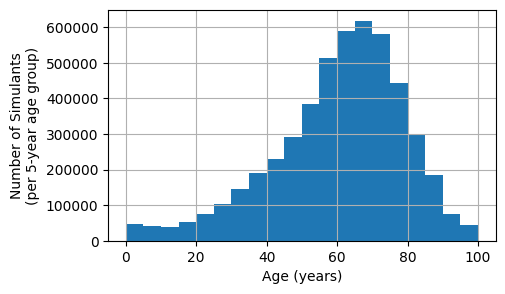

In [24]:
def float_or_nan(x):
    try:
        return float(x)
    except ValueError:
        return np.nan
df_2_final.age.map(float_or_nan).hist(bins=np.arange(0,101,5), figsize=(5,3))
plt.xlabel('Age (years)')
plt.ylabel('Number of Simulants\n(per 5-year age group)')

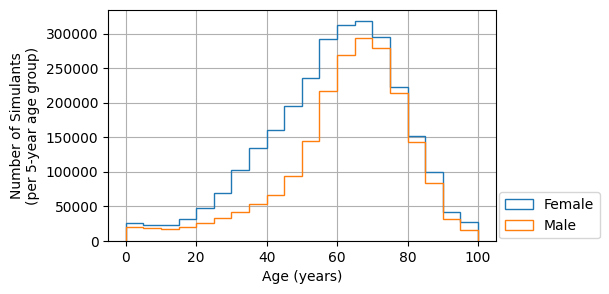

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(5,3))

for s, df_s in df_2_final.groupby('sex', observed=True):
    df_s.age.map(float_or_nan).hist(
        bins=np.arange(0,101,5),
        histtype='step',
        label=s,
        ax=ax
)
plt.xlabel('Age (years)')
plt.ylabel('Number of Simulants\n(per 5-year age group)')
plt.legend(loc=(1.01, .01));

Text(0, 0.5, 'Number of Simulants\n(per 5-year age group)')

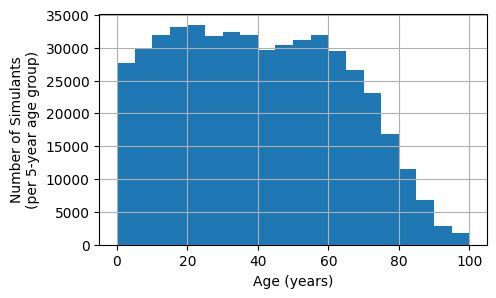

In [26]:
df_1a_final.age.map(float_or_nan).hist(bins=np.arange(0,101,5), figsize=(5,3))
plt.xlabel('Age (years)')
plt.ylabel('Number of Simulants\n(per 5-year age group)')

Text(0, 0.5, 'Number of Simulants\n(per 5-year age group)')

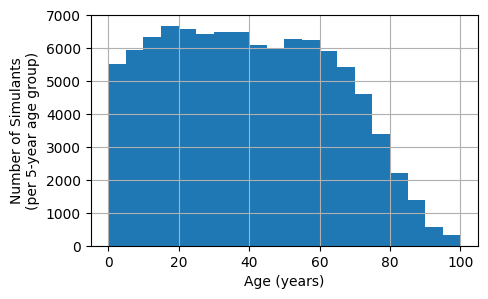

In [27]:
df_1b_final.age.map(float_or_nan).hist(bins=np.arange(0,101,5), figsize=(5,3))
plt.xlabel('Age (years)')
plt.ylabel('Number of Simulants\n(per 5-year age group)')


Finder file df_1a/b: 20% missing SSN, 1% transposition error SSN, 5% missing Address

FCDS file df_2: 5% missing SSN, 0% (no) transposition error SSN, 1% missing Address



In [28]:
df_1a_final.ssn.isnull().mean(), df_1a_final.street_name.isnull().mean()

(0.1999996000008, 0.05023189953620093)

In [29]:
df_1b_final.ssn.isnull().mean(), df_1b_final.street_name.isnull().mean()

(0.2, 0.05038)

In [30]:
df_2_final.ssn.isnull().mean(), df_2_final.street_name.isnull().mean()

(0.0577252614593725, 0.010018575955417707)